In [1]:
from PIL import Image
from skimage import io, color
import requests
from io import BytesIO
import math
from itertools import combinations
from itertools import permutations
import struct
import colorsys
from collections import OrderedDict
from random import sample 

In [2]:
import kmedoids
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
import scipy
import scipy.misc
import scipy.cluster
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import cv2 as cv2
import numpy as np
import scipy.io
import pandas as pd

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

### Importing data

In [6]:
data = scipy.io.loadmat('data/kulerData.mat')
hueProbs = scipy.io.loadmat('data/hueProbsRGB.mat')
huedata = hueProbs['hueProbs']

In [7]:
palette = data['data']
rating = data['targets']

In [8]:
data = hueProbs['hueProbs']

In [9]:
hueProb  = huedata['hueProb']
hueJoint = huedata['hueJoint']
hueAdjacency = huedata['hueAdjacency']
hueSaturation = huedata['hueSaturation']
hueValue = huedata['hueValue']
hueJointRating = huedata['hueJointRating']
hueAdjacencyRating = huedata['hueAdjacencyRating']
hueSaturationRating = huedata['hueSaturationRating']
hueValueRating = huedata['hueValueRating']
hueRatingFactor = huedata['hueRatingFactor']

### Defining Functions

In [10]:
def rgb2hsv(r, g, b):
    h, s, v, = colorsys.rgb_to_hsv(r, g, b)
    return h, s, v

In [11]:
def rgb2chsv(r, g, b):
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    d1 = s*math.cos(h)
    d2 = s*math.sin(h)
    d3 = v
    return d1, d2, d3

In [12]:
def rgb2lab(r, g, b):
    inputColor = [r, g, b]
    num = 0
    RGB = [0, 0, 0]
    for value in inputColor:
        value = float(value) / 255
        if value > 0.04045:
            value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
        else:
            value = value / 12.92
        RGB[num] = value * 100
        num = num + 1
    XYZ = [0, 0, 0,]
    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )
    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883
    num = 0
    for value in XYZ:
        if value > 0.008856:
            value = value ** ( 0.3333333333333333 )
        else:
            value = ( 7.787 * value ) + ( 16 / 116 )
        XYZ[num] = value
        num = num + 1
    Lab = [0, 0, 0]
    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )
    Lab [ 0 ] = round( L, 4 )
    Lab [ 1 ] = round( a, 4 )
    Lab [ 2 ] = round( b, 4 )
    return Lab[0], Lab[1], Lab[2]

In [13]:
def find_dif(col1, col2):
    d1 = abs(col1[0] - col2[0])
    d2 = abs(col1[1] - col2[2])
    d3 = abs(col1[0] - col2[0])
    return d1, d2, d3

In [14]:
def create_features(palette, hueProb, hueJoint, hueAdjacency):
    rgb = np.zeros((len(palette), 3))
    lab = np.zeros((len(palette), 3))
    hsv = np.zeros((len(palette), 3))
    chsv = np.zeros((len(palette), 3))
    rgb_sorted = np.zeros((len(palette), 3))
    lab_sorted = np.zeros((len(palette), 3))
    hsv_sorted = np.zeros((len(palette), 3))
    chsv_sorted = np.zeros((len(palette), 3))
    rgb_diff = np.zeros((4, 3))
    lab_diff = np.zeros((4, 3))
    hsv_diff = np.zeros((4, 3))
    chsv_diff = np.zeros((4, 3))
    rgb_diff_s = np.zeros((4, 3))
    lab_diff_s = np.zeros((4, 3))
    hsv_diff_s = np.zeros((4, 3))
    chsv_diff_s = np.zeros((4, 3))
    rgb_mean = np.zeros(3)
    rgb_std = np.zeros(3)
    rgb_median = np.zeros(3)
    rgb_min = np.zeros(3)
    rgb_max = np.zeros(3)
    lab_mean = np.zeros(3)
    lab_std = np.zeros(3)
    lab_median = np.zeros(3)
    lab_min = np.zeros(3)
    lab_max = np.zeros(3)
    hsv_mean = np.zeros(3)
    hsv_std = np.zeros(3)
    hsv_median = np.zeros(3)
    hsv_min = np.zeros(3)
    hsv_max = np.zeros(3)
    chsv_mean = np.zeros(3)
    chsv_std = np.zeros(3)
    chsv_median = np.zeros(3)
    chsv_min = np.zeros(3)
    chsv_max = np.zeros(3)
    rgb_mmd = np.zeros(3)
    lab_mmd = np.zeros(3)
    hsv_mmd = np.zeros(3)
    chsv_mmd = np.zeros(3)
    hj = np.zeros((5, 5))
    ha = np.zeros((5, 5))
    for i in range(len(palette)):
        rgb[i] = palette[i]
        lab[i] = rgb2lab(rgb[i][0], rgb[i][1], rgb[i][2])
        hsv[i] = rgb2hsv(rgb[i][0], rgb[i][1], rgb[i][2])
        chsv[i] = rgb2chsv(rgb[i][0], rgb[i][1], rgb[i][2]) 
        rgb_sorted[i] = sorted(rgb[i])
        lab_sorted[i] = sorted(lab[i])
        hsv_sorted[i] = sorted(hsv[i])
        chsv_sorted[i] = sorted(chsv[i])
    for i in range(4):
        rgb_diff[i] = find_dif(rgb[i], rgb[i+1])
        lab_diff[i] = find_dif(lab[i], lab[i+1])
        hsv_diff[i] = find_dif(hsv[i], hsv[i+1])
        chsv_diff[i] = find_dif(chsv[i], chsv[i+1])
        rgb_diff_s[i] = sorted(rgb_diff[i])
        lab_diff_s[i] = sorted(lab_diff[i])
        hsv_diff_s[i] = sorted(hsv_diff[i])
        chsv_diff_s[i] = sorted(chsv_diff[i])
    for i in range(3):
        rgb_mean[i] = np.mean(rgb[:, i])
        rgb_std[i] = np.std(rgb[:, i])
        rgb_median[i] = np.median(rgb[:, i])
        rgb_min[i] = min(rgb[:, i])
        rgb_max[i] = max(rgb[:, i])
        lab_mean[i] = np.mean(lab[:, i])
        lab_std[i] = np.std(lab[:, i])
        lab_median[i] = np.median(lab[:, i])
        lab_min[i] = min(lab[:, i])
        lab_max[i] = max(lab[:, i])
        hsv_mean[i] = np.mean(hsv[:, i])
        hsv_std[i] = np.std(hsv[:, i])
        hsv_median[i] = np.median(hsv[:, i])
        hsv_min[i] = min(hsv[:, i])
        hsv_max[i] = max(hsv[:, i])
        chsv_mean[i] = np.mean(chsv[:, i])
        chsv_std[i] = np.std(chsv[:, i])
        chsv_median[i] = np.median(chsv[:, i])
        chsv_min[i] = min(chsv[:, i])
        chsv_max[i] = max(chsv[:, i])
        rgb_mmd[i] = rgb_max[i] - rgb_min[i]
        lab_mmd[i] = lab_max[i] - lab_min[i]
        hsv_mmd[i] = hsv_max[i] - hsv_min[i]
        chsv_mmd[i] = chsv_max[i] - chsv_min[i]
        
    hsv_indices = (hsv[:, 0]*360).astype(int)
    hp_mean = np.mean(hueProb[0][0][hsv_indices]/100.0)
    hp_std = np.std(hueProb[0][0][hsv_indices]/100.0)
    hp_min = np.amin(hueProb[0][0][hsv_indices]/100.0)
    hp_max = np.amax(hueProb[0][0][hsv_indices]/100.0)
    hp_mean_log = np.mean(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_std_log = np.std(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_min_log = np.amin(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_max_log = np.amax(np.log(hueProb[0][0][hsv_indices]/100.0))
    
    for i in range(5):
        for j in range(5):
            hj[i][j] = hueJoint[0][0][hsv_indices[i]][hsv_indices[j]]
            ha[i][j] = hueAdjacency[0][0][hsv_indices[i]][hsv_indices[j]]
            
    hj_mean = np.mean(hj/100.0)
    hj_std = np.std(hj/100.0)
    hj_min = np.min(hj/100.0)
    hj_max = np.max(hj/100.0)
    hj_mean_log = np.mean(np.log((hj/100.0)))
    hj_std_log = np.std(np.log((hj/100.0)))
    hj_min_log = np.min(np.log((hj/100.0)))
    hj_max_log = np.max(np.log((hj/100.0)))
    
    
    ha_mean = np.mean(ha/100.0)
    ha_std = np.std(ha/100.0)
    ha_min = np.min(ha/100.0)
    ha_max = np.max(ha/100.0)
    ha_mean_log = np.mean(np.log((ha/100.0)))
    ha_std_log = np.std(np.log((ha/100.0)))
    ha_min_log = np.min(np.log((ha/100.0)))
    ha_max_log = np.max(np.log((ha/100.0)))

    result = (np.ravel(rgb), np.ravel(rgb_sorted), np.ravel(rgb_diff), np.ravel(rgb_diff_s), np.ravel(rgb_mean),np.ravel(rgb_std), np.ravel(rgb_median), np.ravel(rgb_max), np.ravel(rgb_min), np.ravel(rgb_mmd), np.ravel(lab), np.ravel(lab_sorted), np.ravel(lab_diff), np.ravel(lab_diff_s), np.ravel(lab_mean),np.ravel(lab_std), np.ravel(lab_median), np.ravel(lab_max), np.ravel(lab_min), np.ravel(lab_mmd), np.ravel(chsv), np.ravel(chsv_sorted), np.ravel(chsv_diff), np.ravel(chsv_diff_s), np.ravel(chsv_mean),np.ravel(chsv_std), np.ravel(chsv_median), np.ravel(chsv_max), np.ravel(chsv_min), np.ravel(chsv_mmd), np.ravel(hsv), np.ravel(hsv_sorted), np.ravel(hsv_diff), np.ravel(hsv_diff_s), np.ravel(hsv_mean),np.ravel(hsv_std), np.ravel(hsv_median), np.ravel(hsv_max), np.ravel(hsv_min), np.ravel(hsv_mmd), np.ravel(hp_mean), np.ravel(hp_std), np.ravel(hp_max), np.ravel(hp_min), np.ravel(hp_mean_log), np.ravel(hp_std_log), np.ravel(hp_max_log), np.ravel(hp_min_log), np.ravel(ha_mean), np.ravel(ha_std), np.ravel(ha_max), np.ravel(ha_min), np.ravel(ha_mean_log), np.ravel(ha_std_log), np.ravel(ha_max_log), np.ravel(ha_min_log), np.ravel(hj_mean), np.ravel(hj_std), np.ravel(hj_max), np.ravel(hj_min), np.ravel(hj_mean_log), np.ravel(hj_std_log), np.ravel(hj_max_log), np.ravel(hj_min_log))
    r = np.concatenate(result).ravel()
    #result = np.ndarray.flatten(np.array(np.ravel(rgb), np.ravel(rgb_sorted), np.ravel(rgb_diff), np.ravel(rgb_diff_s), np.ravel(rgb_mean), np.ravel(rgb_std), np.ravel(rgb_median), np.ravel(rgb_min), np.ravel(rgb_max), np.ravel(rgb_mmd))
    #r = np.ravel(result)
    #print (len(r))
    return r
    
    #print((hueJoint[0][0][(hsv[:, 0]*360).astype(int)]/100.0))
    #print((hueJoint[0][0][(hsv[:, 0]*360).astype(int)][np.transpose((hsv[:, 0]*360).astype(int))])

### Creating Feature Vector

In [15]:
w = len(palette)
h = 312
features = np.zeros((w, h))

In [16]:
for i in range(w):
    features[i] = create_features(palette[i], hueProb, hueJoint, hueAdjacency)
    if(i%1000 == 0):
        print (int(i/1000.0))

0


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in log


1
2
3
4
5
6
7
8


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: divide by zero encountered in log


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


Check whether there are NaNs and inf-s in data and replace them with 0:

In [17]:
features_clean = features
features_clean[np.isnan(features_clean)] = 0
features_clean[np.isinf(features_clean)] = 0

In [18]:
print(np.any(np.isnan(features_clean)))
print(np.all(np.isfinite(features_clean)))

False
True


In [19]:
ratings_clean = rating
ratings_clean[np.isnan(ratings_clean)] = 0
ratings_clean[np.isinf(ratings_clean)] = 0

### Prepare train and test data:

In [20]:
X = features_clean
Y = ratings_clean

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)

### MLPClassifier:

In [22]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn import cross_validation

In [23]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(activation='logistic')

In [24]:
mlp.fit(X_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [25]:
predictions = mlp.predict(X_test)

In [26]:
rmse = np.sqrt(mean_squared_error(y_test,predictions))
rmse

0.6767468742758065

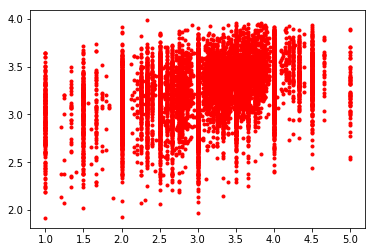

In [27]:
plt.plot(y_test, predictions, 'r.')
plt.show()

# Defining functions

In [28]:
def pixel_rgb2lab(r, g, b):
    inputColor = [r, g, b]
    num = 0
    RGB = [0, 0, 0]
    for value in inputColor:
        value = float(value) / 255
        if value > 0.04045:
            value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
        else:
            value = value / 12.92
        RGB[num] = value * 100
        num = num + 1
    XYZ = [0, 0, 0,]
    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )
    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883
    num = 0
    for value in XYZ:
        if value > 0.008856:
            value = value ** ( 0.3333333333333333 )
        else:
            value = ( 7.787 * value ) + ( 16 / 116 )
        XYZ[num] = value
        num = num + 1
    Lab = [0, 0, 0]
    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )
    Lab [ 0 ] = max(0, min(round( L, 4 ), 100))
    Lab [ 1 ] = max(-128, min(round( a, 4 ), 128))
    Lab [ 2 ] = max(-128, min(round( b, 4 ), 128))
    return Lab

In [29]:
def image_rgb2lab(image_rgb):
    image_lab = np.zeros((image_rgb.shape[0], image_rgb.shape[1], 3))
    for i in range(image_rgb.shape[0]):
        for j in range(image_rgb.shape[1]):
            image_lab[i, j] = pixel_rgb2lab(image_rgb[i, j, 0], image_rgb[i, j, 1], image_rgb[i, j, 2])
    return image_lab

In [30]:
def pixel_lab2rgb(l, a , b):
    
    fY = pow((l + 16)/116, 3)
    if fY < 0.008856:
        fY = l/903.3
    Y = fY
    
    if fY > 0.008856:
        fY = pow(fY, 1/3)
    else:
        fY = 7.787 * fY + 16/116
    
    fX = a / 500 + fY
    if fX > 0.206893:
        X = pow(fX, 3)
    else:
        X = (fX - 16/116) / 7.787
    
    fZ = fY - b/200
    if fZ > 0.206893:
        Z = pow(fZ, 3)
    else:
        Z = (fZ - 16/116) / 7.787
    
    X = X * 0.950456 * 255
    Y = Y * 255
    Z = Z * 1.088754 * 255
    
    RR = (int)(3.240479 * X - 1.537150 * Y - 0.498535 * Z + 0.5)
    GG = (int)(-0.969256 * X + 1.875992 * Y + 0.047556 * Z + 0.5)
    BB = (int)(0.055648 * X - 0.204043 * Y + 1.057311 * Z + 0.5)
    
    if RR < 0 : R = 0
    elif RR > 255: R = 255
    else : R = RR
        
    if GG < 0 : G = 0
    elif GG > 255 : G = 255
    else : G = GG
    
    if BB < 0 : B = 0
    elif BB > 255 : B = 255
    else : B = BB
        
    RGB = [0, 0, 0]
    RGB[0] = R
    RGB[1] = G
    RGB[2] = B
    
    return RGB

In [31]:
def palette_hsv2rgb(palette):
    palette_rgb = np.zeros((palette.shape[0], 3))
    for i in range(palette.shape[0]):
            palette_rgb[i] = colorsys.hsv_to_rgb(palette[i, 0], palette[i, 1], palette[i, 2])
            palette_rgb[i, 0] = palette_rgb[i, 0] * 255
            palette_rgb[i, 1] = palette_rgb[i, 1] * 255
            palette_rgb[i, 2] = palette_rgb[i, 2] * 255
    return palette_rgb

In [32]:
def palette_rgb2hsv(palette):
    palette_hsv = np.zeros((palette.shape[0], 3))
    for i in range(palette.shape[0]):
            palette_hsv[i] = colorsys.rgb_to_hsv(palette[i, 0], palette[i, 1], palette[i, 2])
            palette_hsv[i, 0] = palette_hsv[i, 0] * 255
            palette_hsv[i, 1] = palette_hsv[i, 1] * 255
            palette_hsv[i, 2] = palette_hsv[i, 2] * 255
    return palette_hsv

In [33]:
def image_rgb2lab(image_lab):
    image_rgb = np.zeros((image_lab.shape[0], image_lab.shape[1], 3))
    for i in range(image_lab.shape[0]):
        for j in range(image_lab.shape[1]):
            image_rgb[i, j] = pixel_rgb2lab(image_lab[i, j, 0], image_lab[i, j, 1], image_lab[i, j, 2])
    return image_rgb

In [34]:
def distinct_pixels(image_array):
    image_flat = image_array.reshape((int(image_array.size/3), 3))
    image_distinct_list = list(map(list, OrderedDict.fromkeys(map(tuple, image_flat))))
    image_distinc = np.array(image_distinct_list)
    return image_distinc

In [35]:
def number_of_elements(image_array, pixel_array):
    distinct_count = np.zeros((pixel_array.shape[0]))
    pixel_list = pixel_array.tolist()
    for i in range (pixel_array.shape[0]):
        distinct_count[i] = image_array.count(pixel_list[i])
    return distinct_count

In [36]:
def clustering(image, n):
    peal = np.zeros((n))
    image_flat = image.reshape(scipy.product(image.shape[:2]), image.shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(image_flat, n)
    return codes

In [37]:
def k_means(image, n): 
    arr = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n, random_state=42).fit(arr)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    #less_colors = centers[labels]
    
    return centers

In [38]:
def classify_color(rgb, hueProb, hueJoint, hueAdjacency):
    features = create_features(rgb, hueProb, hueJoint, hueAdjacency)
    rating = mlp.predict(np.matrix((features)).T.T)[0]
    
    if rating > 3.11:
        classification = 'good'
    else:
        classification = 'bad'
    return classification

In [39]:
def predict_from_color(rgb, hueProb, hueJoint, hueAdjacency):
    features = create_features(rgb, hueProb, hueJoint, hueAdjacency)
    rating = mlp.predict(np.matrix((features)).T.T)[0]
    return rating

In [40]:
def max_distance(color, theme):
    max_distance = -math.inf
    for i in range(theme.shape[0]):
        distance = math.sqrt((theme[i, 0] - color[0])**2 + (theme[i, 1] - color[1])**2 + (theme[i, 2] - color[2])**2)
        if max_distance < distance:
            max_distance = distance
    return max_distance

In [41]:
def theme_distance(theme_color, color, color_count, m):
    distances = np.zeros((color.shape[0]))
    for i in range(color.shape[0]):
        distances[i] = math.sqrt((color[i, 0] - theme_color[0])**2 + (color[i, 1] - theme_color[1])**2 + (color[i, 2] - theme_color[2])**2)
    
    #color_sorted = [x for _,x in sorted(zip(distances, color))]
    count_sorted = np.array([x for _,x in sorted(zip(distances, color_count))])
    distance_sorted = np.array([x for _,x in sorted(zip(distances, distances))])
    
    max_distance = 0
    
    for i in range (distance_sorted.shape[0]):
        if count_sorted[i] * i >= m:
            max_distance = distance_sorted[i]
            i = distance_sorted.shape[0]+1
            
    return max_distance

In [42]:
def find_palette_colors(image, pixel_lab, distinct_count, hueProb, hueJoint, hueAdjacency, alpha = 0):
    n=5
    dominant_colors = np.array(k_means(image, int(10)))
    color_themes_list = permutations(dominant_colors, n)
    color_themes_lab = np.array(list(color_themes_list))
    
    pixel_num = image.shape[0] * image.shape[1]
    m = pixel_num/20
    betta = 0.25
    
    color_themes_rgb = np.zeros((color_themes_lab.shape[0], color_themes_lab.shape[1], 3))
    for i in range (color_themes_lab.shape[0]):
        for j in range (color_themes_lab.shape[1]):
            color_themes_rgb[i, j] = pixel_lab2rgb(color_themes_lab[i, j, 0], color_themes_lab[i, j, 1], color_themes_lab[i, j, 2])
            
    max_rating = -math.inf
    palette = np.zeros((n, 3))
    
    penalty1 = np.zeros((dominant_colors.shape[0]))
    for i in range(dominant_colors.shape[0]):
        for j in range(pixel_lab.shape[0]):
            penalty1[i] += distinct_count[j] * max_distance(pixel_lab[j], color_themes_lab[i])
            
    
    for i in range(color_themes_lab.shape[0]):

        rating = 0
        
        if alpha > 0:
            rating += predict_from_color(color_themes_rgb[i]/255, hueProb, hueJoint, hueAdjacency)

            rating = rating / (color_themes_lab.shape[1] - 4)
                    
        rating = rating * alpha

        penalty = 0
        
        for j in range(penalty1.shape[0]):
            for k in range(color_themes_lab.shape[1]):
                if color_themes_lab[i, k, 0] == dominant_colors[j, 0] and  color_themes_lab[i, k, 1] == dominant_colors[j, 1] and color_themes_lab[i, k, 2] == dominant_colors[j, 2]:
                    penalty += penalty1[j]
        
        penalty = penalty / pixel_num
        overal_rating = rating - penalty
        
        if rating > max_rating:
            max_rating = rating
            palette = color_themes_lab[i]
            
    return palette

In [43]:
def rgb2ColorCode(theme):
    colorCode = list()
    for i in range(theme.shape[0]):
         colorCode.append('#%02x%02x%02x' % (int(theme[i, 0]), int(theme[i, 1]), int(theme[i, 2])))
    return colorCode

In [178]:
def dominant_colors(image, alpha, hueProb, hueJoint, hueAdjacency):
    image_lab = image
    image_lab_flat = image_lab.copy().reshape((int(image_lab.size/3), 3))
    image_lab_distinct = distinct_pixels(image_lab)
    image_lab_distinct_count = number_of_elements(image_lab_flat.tolist(), image_lab_distinct.copy())
    theme = find_palette_colors(image_lab, image_lab_distinct, image_lab_distinct_count, hueProb, hueJoint, hueAdjacency, alpha)    
    
    if alpha == 0:
        theme_hsv = palette_rgb2hsv(np.array(theme))
        value = theme_hsv[:,1]
        theme = np.array([x for _,x in sorted(zip(value,theme))])
    
    sns.set(rc = {"figure.figsize": (5, 5)})
    current_palette = rgb2ColorCode(theme)
    sns.palplot(sns.color_palette(current_palette))
    

In [174]:
def dominant_colors_k_mean(image):
    theme = k_means(image, 5)
    
    theme_hsv = palette_rgb2hsv(np.array(theme))
    value = theme_hsv[:,1]
    theme_sorted = np.array([x for _,x in sorted(zip(value,theme))])
    
    
    sns.set(rc = {"figure.figsize": (5, 5)})
    current_palette = rgb2ColorCode(theme_sorted)
    sns.palplot(sns.color_palette(current_palette))

In [46]:
def k_medoid(image):
    
    data = image.reshape((int(image.size/3), 3))
    D = pairwise_distances(data, metric='euclidean')
    M, C = kmedoids.kMedoids(D, 5)
    metoids = np.zeros((5, 3))
    i = 0
    for point_idx in M:
        metoids[i] = data[point_idx]
        i += 1
        
    metoids_hsv = palette_rgb2hsv(np.array(metoids))
    value = metoids_hsv[:,1]
    theme_sorted = np.array([x for _,x in sorted(zip(value, metoids))])
    
    sns.set(rc = {"figure.figsize": (5, 5)})
    current_palette = rgb2ColorCode(theme_sorted)
    sns.palplot(sns.color_palette(current_palette))
    


# Dominant Colors

In [171]:
response = requests.get("https://66.media.tumblr.com/a4ad29805f57754e036dde2aba910bdd/tumblr_obwvkkGelW1s0u653o8_1280.jpg")
ig = Image.open(BytesIO(response.content))
ig = ig.resize((50,50), Image.NEAREST)
img = np.array(ig)

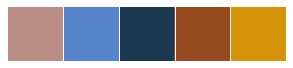

In [175]:
dominant_colors_k_mean(img)

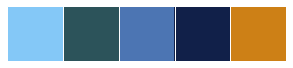

In [173]:
k_medoid(img)

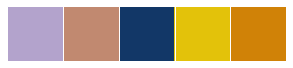

In [179]:
dominant_colors(img, 0, hueProb, hueJoint, hueAdjacency)

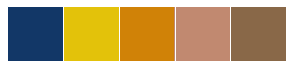

In [180]:
dominant_colors(img, 3, hueProb, hueJoint, hueAdjacency)